In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import time

# custom functions
from functions import *

import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

2024-11-17 02:28:05.548456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731806885.567555   92212 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731806885.573129   92212 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 02:28:05.591408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('../data/clean/dataset.csv').fillna('')

In [3]:
df

,name,url,title,lemmes,funny
0,le_monde,https://www.lemonde.fr/disparitions/article/20...,"Simon Fieschi, grièvement blessé pendant l’att...",simon fieschi grievement blesser attentat cont...,0
1,le_monde,https://www.lemonde.fr/idees/article/2024/10/1...,« Il faut expliquer la différence entre les ef...,falloir expliquer difference effet concret imm...,0
2,le_monde,https://www.lemonde.fr/economie/article/2024/1...,Le périphérique a désormais son outil évaluate...,peripherique outil evaluateur kilometre heure,0
3,le_monde,https://www.lemonde.fr/economie/article/2024/1...,"En Occitanie, les agriculteurs mécontents mult...",occitanie agriculteur mecontent multiplier act...,0
4,le_monde,https://www.lemonde.fr/les-decodeurs/article/2...,Présidentielle américaine 2024 : comment Donal...,presidentielle americain donald trump instrume...,0
...,...,...,...,...,...
106557,ouest_france,https://www.ouest-france.fr/pays-de-la-loire/t...,Le défi Foyers à alimentation positive d’Erd...,defi foyers alimentation positif erdre gesvre ...,0
106558,ouest_france,https://www.ouest-france.fr/sport/football/red...,"Football. Le propriétaire du Red Star, 777 Pa...",football proprietaire red star partners failli...,0
106559,ouest_france,https://www.ouest-france.fr/normandie/lisieux-...,"Plus d’un an après les émeutes à Lisieux, l...",an apres emeute lisieux poste police municipal...,0
106560,ouest_france,https://www.ouest-france.fr/bretagne/finistere...,Le Sud-Finistère célèbre la culture urbaine...,sud finistere celebre culture urbain etat,0


In [4]:
from transformers import TFAutoModel, AutoTokenizer
import tensorflow as tf
import numpy as np
from tqdm import tqdm

# Load the CamemBERT model and tokenizer
model_name = "camembert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)

# Example list of 100,000 sentences (replace with your actual data)
sentences = list(df['title'])

# Define batch size for processing
batch_size = 32  # Adjust based on available memory

# Function to extract embeddings for a batch of sentences
def extract_embeddings(batch_sentences):
    # Tokenize and encode the batch of sentences
    inputs = tokenizer(
        batch_sentences, return_tensors="tf", padding=True, truncation=True
    )
    
    # Get model outputs
    outputs = model(**inputs)
    
    # Pool the embeddings by averaging token embeddings
    sentence_embeddings = tf.reduce_mean(outputs.last_hidden_state, axis=1)
    return sentence_embeddings

# Loop through sentences in batches and store the embeddings
all_embeddings = []
num_batches = len(sentences) // batch_size + (len(sentences) % batch_size != 0)

for i in tqdm(range(0, len(sentences), batch_size), total=num_batches, desc="Encoding Batches"):
    batch_sentences = sentences[i:i + batch_size]
    batch_embeddings = extract_embeddings(batch_sentences)
    all_embeddings.append(batch_embeddings)

# Concatenate all batch embeddings into a single tensor
all_embeddings = tf.concat(all_embeddings, axis=0)

# Convert to NumPy array if needed for downstream processing
all_embeddings_np = all_embeddings.numpy()

print("Shape of embeddings:", all_embeddings_np.shape)  # Should be (100000, hidden_size)

I0000 00:00:1731806894.985722   92212 gpu_process_state.cc:201] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1731806894.985914   92212 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1730 MB memory:  -> device: 0, name: NVIDIA GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCamembertModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFCamembertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassi

Shape of embeddings: (106562, 768)


<Figure size 800x600 with 0 Axes>

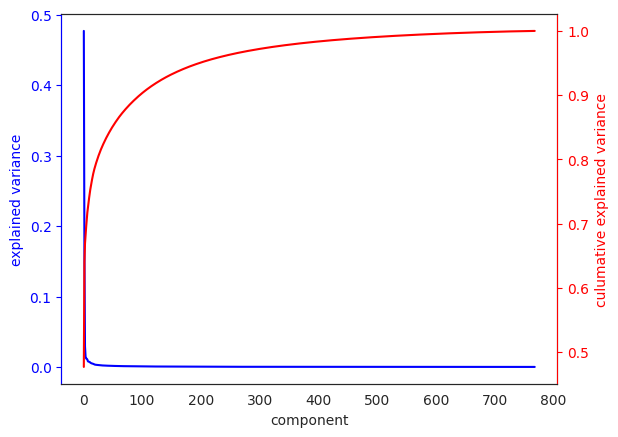

In [5]:
pca_graph(all_embeddings_np)

In [6]:
y = df.funny

In [7]:
mapper = umap.UMAP(n_components=2, n_jobs=-1, verbose=1, random_state=314).fit(all_embeddings_np)    

/home/michael/.pyenv/versions/funnypress-data-study/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=314, verbose=1)
Sun Nov 17 02:51:32 2024 Construct fuzzy simplicial set
Sun Nov 17 02:51:32 2024 Finding Nearest Neighbors
Sun Nov 17 02:51:32 2024 Building RP forest with 21 trees
Sun Nov 17 02:51:50 2024 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	 6  /  17
	Stopping threshold met -- exiting after 6 iterations
Sun Nov 17 02:52:25 2024 Finished Nearest Neighbor Search
Sun Nov 17 02:52:29 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sun Nov 17 02:54:04 2024 Finished embedding


In [8]:
embedding = mapper.transform(all_embeddings_np)

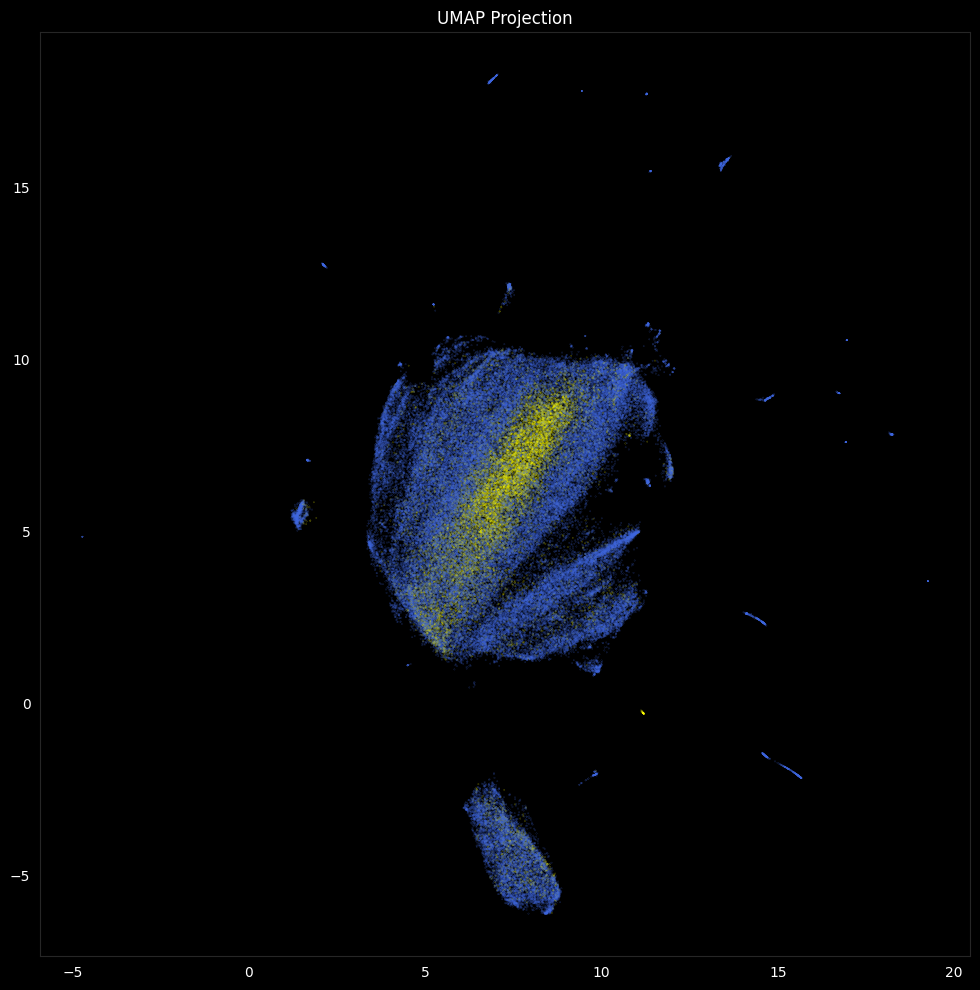

In [9]:
# Plot the result
plt = umap_plt(embedding, y)
plt.show()

In [10]:
mean_point = all_embeddings_np[y==1].mean(axis=0)

In [11]:
median_point = np.median(all_embeddings_np[y==1], axis=0)

In [12]:
mean_umap = mapper.transform([mean_point])[0]
median_umap = mapper.transform([median_point])[0]

Sun Nov 17 02:54:13 2024 Worst tree score: 0.33249188
Sun Nov 17 02:54:13 2024 Mean tree score: 0.33871719
Sun Nov 17 02:54:13 2024 Best tree score: 0.34457874
Sun Nov 17 02:54:17 2024 Forward diversification reduced edges from 1598430 to 714842
Sun Nov 17 02:54:21 2024 Reverse diversification reduced edges from 714842 to 714842
Sun Nov 17 02:54:24 2024 Degree pruning reduced edges from 874364 to 861046
Sun Nov 17 02:54:24 2024 Resorting data and graph based on tree order
Sun Nov 17 02:54:25 2024 Building and compiling search function


Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


Epochs completed:   0%|            0/100 [00:00]

	completed  0  /  100 epochs
	completed  10  /  100 epochs
	completed  20  /  100 epochs
	completed  30  /  100 epochs
	completed  40  /  100 epochs
	completed  50  /  100 epochs
	completed  60  /  100 epochs
	completed  70  /  100 epochs
	completed  80  /  100 epochs
	completed  90  /  100 epochs


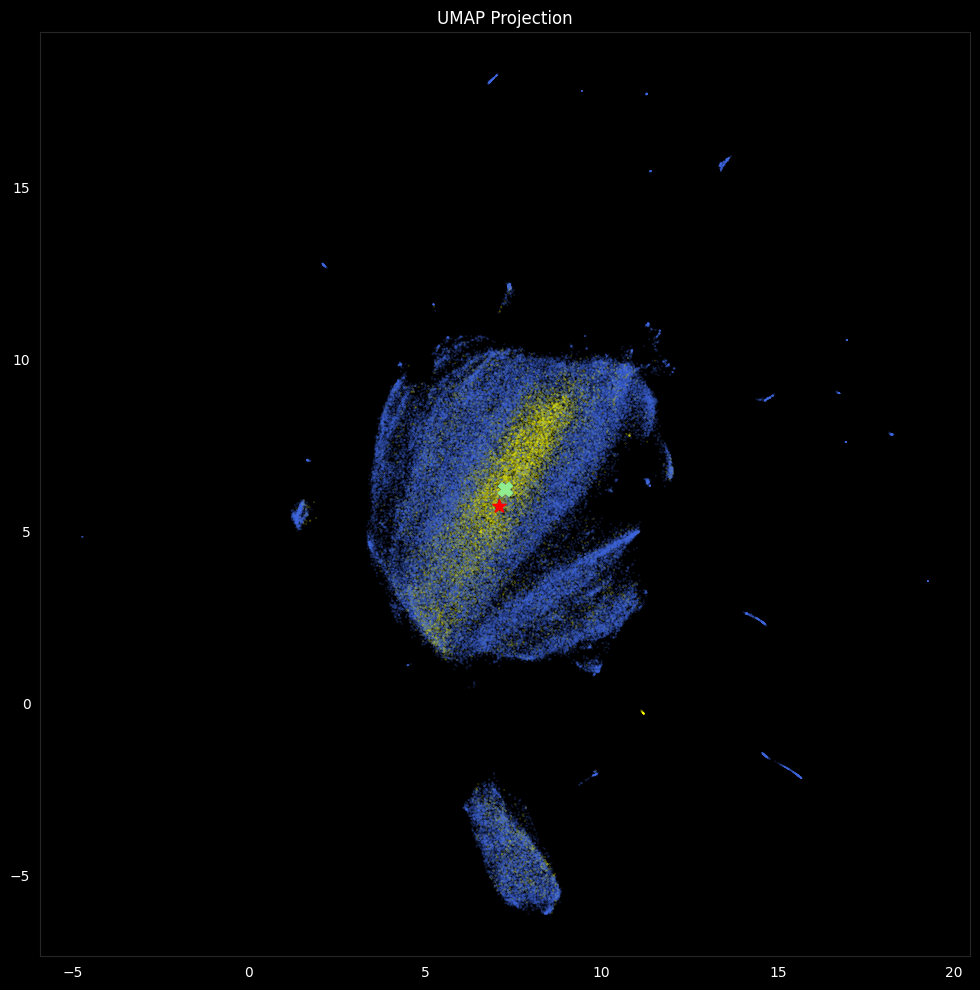

In [13]:
plt = umap_plt(embedding, y)

plt.scatter(mean_umap[0], mean_umap[1], color='red', s=100, marker='*', label="Mean Point")
plt.scatter(median_umap[0], median_umap[1], color='lightgreen', s=100, marker='X', label="Median Point")

plt.show()

In [14]:
distances = np.linalg.norm(all_embeddings_np - median_point, axis=1)

In [15]:
df['distance'] = distances

In [16]:
df.sort_values(by='distance').reset_index(drop=True)[['url', 'title', 'distance']]

,url,title,distance
0,https://www.huffingtonpost.fr/actualites/artic...,VIDÉOS. Ce papa expert en effets spéciaux fa...,0.868083
1,https://www.huffingtonpost.fr/actualites/artic...,PHOTOS. Richard Branson se déguise en hôtess...,0.877121
2,https://www.ulyces.co/news/aux-philippines-un-...,"Aux Philippines, un père fait une coupe horri...",0.885372
3,https://www.huffingtonpost.fr/actualites/artic...,VIDÉO. Pendant une bagarre entre joueurs de h...,0.895124
4,https://www.huffingtonpost.fr/actualites/artic...,VIDÉO. Cette expérience pédagogique sur les...,0.900211
...,...,...,...
106557,https://www.rfi.fr/fr/podcasts/la-parlotte-de-...,Le mariage imaginaire,9.923869
106558,https://www.leparisien.fr/politique/etat-magiq...,État magique,10.056468
106559,https://www.ladepeche.fr/2024/09/29/serenitarn...,Sérénitarn mobilisé,10.065977
106560,https://www.lemonde.fr/blog/uneanneeaulycee/20...,Octobre,10.211682


In [17]:
for row in df.sort_values(by='distance').reset_index(drop=True)[['url', 'title', 'distance']].head(10).itertuples(index=True, name='Row'):
    print(row.url, row.title, row.distance)

https://www.huffingtonpost.fr/actualites/article/videos-ce-papa-expert-en-effets-speciaux-fait-encore-la-joie-de-son-fils_43301.html VIDÉOS. Ce papa expert en effets spéciaux fait (encore) la joie de son fils 0.8680825233459473
https://www.huffingtonpost.fr/actualites/article/photos-richard-branson-se-deguise-en-hotesse-de-l-air-apres-un-pari-perdu-avec-le-patron-de-lotus_18590.html PHOTOS. Richard Branson se déguise en hôtesse de l'air après un pari perdu avec le patron de Lotus 0.8771207928657532
https://www.ulyces.co/news/aux-philippines-un-pere-fait-une-coupe-horrible-a-son-fils-pour-quil-respecte-le-confinement/ Aux Philippines, un père fait une coupe horrible à son fils pour qu’il respecte le confinement 0.8853718042373657
https://www.huffingtonpost.fr/actualites/article/video-pendant-une-bagarre-entre-joueurs-de-hockey-ce-journaliste-fredonne-un-chant-de-noel_69163.html VIDÉO. Pendant une bagarre entre joueurs de hockey, ce journaliste fredonne un chant de Noël 0.895124

In [18]:
df[df['funny']==0].sort_values(by='distance').reset_index(drop=True)[['url', 'title', 'distance']]

,url,title,distance
0,https://www.ladepeche.fr/2024/09/28/video-leon...,"VIDEO. Léon Marchand : ""Tu verrais mon étagère...",0.913639
1,https://www.lemonde.fr/sport/video/2024/08/05/...,"Paris 2024 : pourquoi Joel Embiid, basketteur ...",0.921635
2,https://www.leparisien.fr/seine-et-marne-77/tr...,Triple meurtre de Mormant : la cellule d’urgen...,0.922425
3,https://www.leparisien.fr/faits-divers/marseil...,Marseille : le domicile de l’influenceuse Maev...,0.932867
4,https://www.francetvinfo.fr/replay-radio/les-i...,Léon Marchand à l'assaut d'une nouvelle médail...,0.935666
...,...,...,...
86790,https://www.rfi.fr/fr/podcasts/la-parlotte-de-...,Le mariage imaginaire,9.923869
86791,https://www.leparisien.fr/politique/etat-magiq...,État magique,10.056468
86792,https://www.ladepeche.fr/2024/09/29/serenitarn...,Sérénitarn mobilisé,10.065977
86793,https://www.lemonde.fr/blog/uneanneeaulycee/20...,Octobre,10.211682


In [19]:
for row in df[df['funny']==0].sort_values(by='distance').reset_index(drop=True)[['url', 'title', 'distance']].head(100).itertuples(index=True, name='Row'):
    print(row.url, row.title, row.distance)

https://www.ladepeche.fr/2024/09/28/video-leon-marchand-tu-verrais-mon-etagere-jen-ai-une-vingtaine-le-nageur-star-revele-un-nouveau-talent-inattendu-12227002.php VIDEO. Léon Marchand : "Tu verrais mon étagère, j’en ai une vingtaine…" Le nageur star révèle un nouveau talent inattendu ! 0.913639485836029
https://www.lemonde.fr/sport/video/2024/08/05/paris-2024-pourquoi-joel-embiid-basketteur-americain-se-fait-huer-a-chacun-de-ses-matchs_6268855_3242.html Paris 2024 : pourquoi Joel Embiid, basketteur américain, se fait huer à chacun de ses matchs ? 0.9216352105140686
https://www.leparisien.fr/seine-et-marne-77/triple-meurtre-de-mormant-la-cellule-durgence-aide-les-riverains-a-absorber-le-choc-08-09-2024-GXYFP7K4SZGYTKOH26WMEOJN6I.php Triple meurtre de Mormant : la cellule d’urgence aide les riverains à « absorber le choc » 0.9224247932434082
https://www.leparisien.fr/faits-divers/marseille-le-domicile-de-linfluenceuse-maeva-ghennam-vise-par-des-coups-de-feu-09-09-2024-KUMTLMFEJNBCDEPNBS